In [1]:
!pip install git+https://github.com/keepsimpler/zero

  Cloning https://github.com/keepsimpler/zero to /tmp/pip-req-build-qxuvkgji
  Running command git clone -q https://github.com/keepsimpler/zero /tmp/pip-req-build-qxuvkgji
     |████████████████████████████████| 61kB 2.8MB/s eta 0:00:011
     |████████████████████████████████| 3.9MB 9.9MB/s eta 0:00:01
  Created wheel for zero: filename=zero-0.1.0-cp36-none-any.whl size=8912 sha256=26e9601ec4c55952a564171fdec22511d7761dd26ffd998240265b2dc6495c7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-iad8d2qf/wheels/f9/0b/48/e2af05e00e92a97baf3de19591f11460fb05f80592f583da00


  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.5.2.1-cp36-none-any.whl size=62478 sha256=31cab77be42555f2bf1aac14c70c2cbbee52460d2359f95b8a22c248fd1af6d4
  Stored in directory: /tmp/.cache/pip/wheels/20/49/24/fff73c46de9d31273c826560c191c3b1c9f7a8696e11fd0739
  Created wheel for test-tube: filename=test_tube-0.7.1-cp36-none-any.whl size=22614 sha256=48d28bd8772b8290914e4118cd40d90b3531462c2e6a3bcda7d38928dc4dcc18
  Stored in directory: /tmp/.cache/pip/wheels/4a/f1/20/a57e7fe148c936a784473ceff49e01f6570746e617fdf8202f
Successfully built zero pytorch-lightning test-tube


In [2]:
from zero import *

In [3]:
def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

In [4]:
data = get_data(size=128, woof=True, bs=64)

In [25]:
model = folded_resnet(Stem = conv_bn, Stage = ResStage, Unit = xception, ni=64,
                      num_stages=5, num_units=10, exp=1, first_downsample=False)

In [26]:
num_params(model)

tensor(22018346)

In [27]:
learn = Learner(data, model, metrics=accuracy).to_fp16()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.74E-04


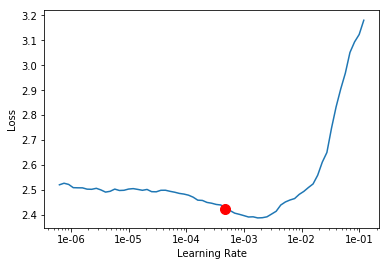

In [19]:
learn.recorder.plot(suggestion=True) 

Min numerical gradient: 1.32E-04
Min loss divided by 10: 3.02E-04


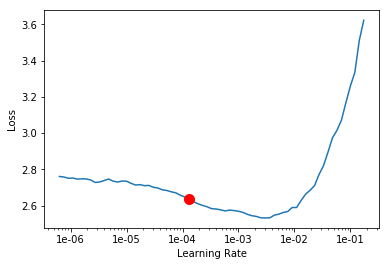

In [29]:
learn.recorder.plot(suggestion=True) 

In [ ]:
for _ in range(1):
    model = folded_resnet(Stem = conv_bn, Stage = ResStage, Unit = xception, ni=64,
                          num_stages=5, num_units=10, exp=1, first_downsample=False)
    learn = Learner(data, model, metrics=accuracy).to_fp16()
    learn.fit_one_cycle(40, 1e-3) 